In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score,roc_auc_score, plot_roc_curve, classification_report, plot_confusion_matrix
import seaborn as sn

In [5]:
tracts = pd.read_parquet('./data/tracts_joined.parquet')
lots = pd.read_parquet('./data/lots_joined.parquet')
all_lots = pd.read_parquet('./data/all_lots.parquet')
# lots_geo = gp.read_file('./input/lots_clean.geojson')
complaints = pd.read_parquet('./data/complaints_joined.parquet')

In [6]:
def binary_classification_performance(y_test, y_pred):
    tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()
    accuracy = round(accuracy_score(y_pred = y_pred, y_true = y_test),2)
    precision = round(precision_score(y_pred = y_pred, y_true = y_test),2)
    recall = round(recall_score(y_pred = y_pred, y_true = y_test),2)
    f1_score = round(2*precision*recall/(precision + recall),2)
    specificity = round(tn/(tn+fp),2)
    npv = round(tn/(tn+fn),2)
    auc_roc = round(roc_auc_score(y_score = y_pred, y_true = y_test),2)


    result = pd.DataFrame({'Accuracy' : [accuracy],
                         'Precision (or PPV)' : [precision],
                         'Recall (senitivity or TPR)' : [recall],
                         'f1 score' : [f1_score],
                         'AUC_ROC' : [auc_roc],
                         'Specificty (or TNR)': [specificity],
                         'NPV' : [npv],
                         'True Positive' : [tp],
                         'True Negative' : [tn],
                         'False Positive':[fp],
                         'False Negative':[fn]})
    return result

In [7]:
def get_medians_by_quintiles(frame, _features, target, title):
  features = _features.copy()
  features.insert(0,target)
  results = []
  for feature in features:
    first = frame[feature].quantile(0.20)
    second = frame[feature].quantile(0.40)
    third = frame[feature].quantile(0.60)
    fourth = frame[feature].quantile(0.80)
    results.append({
        'feature': feature,
        'first': frame[frame[feature] <= first][target].median(),
        'second': frame[(frame[feature] > first) & (frame[feature] <= second)][target].median(),
        'third': frame[(frame[feature] > second) & (frame[feature] <= third)][target].median(),
        'fourth': frame[(frame[feature] > third) & (frame[feature] <= fourth)][target].median(),
        'fifth': frame[frame[feature] >= fourth][target].median()
    })
  medians_by_quartiles = pd.DataFrame(results)
  ax = plt.axes()
  if target == 'median_age':
    sn.heatmap(medians_by_quartiles.set_index('feature'), cmap ='RdYlGn', linewidths = 0.30, annot = True, fmt='g')
  else:
    sn.heatmap(medians_by_quartiles.set_index('feature'), cmap ='RdYlGn_r', linewidths = 0.30, annot = True)
  ax.set_title(title)
  plt.show()


In [8]:
features = ['percent_pre_1960','percent_bachelors', 'percent_high_school', 'median_income',
       'population', 'percent_white', 'percent_african_american',
       'percent_asian', 'percent_latino', 'percent_under_5', 'percent_5_to_9',
       'median_age', 'median_value_per_sqft',
       'median_sqft_per_unit']

In [9]:
tracts.persons_per_unit.max()

4426.0

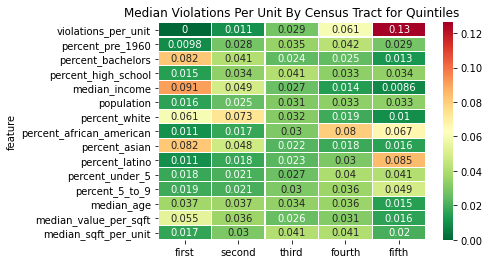

In [10]:
features = ['percent_pre_1960','percent_bachelors', 'percent_high_school', 'median_income',
       'population', 'percent_white', 'percent_african_american',
       'percent_asian', 'percent_latino', 'percent_under_5', 'percent_5_to_9',
       'median_age', 'median_value_per_sqft',
       'median_sqft_per_unit']
get_medians_by_quintiles(tracts, features, 'violations_per_unit', 'Median Violations Per Unit By Census Tract for Quintiles')

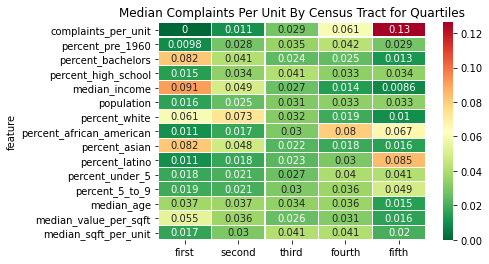

In [11]:
features = ['percent_pre_1960','percent_bachelors', 'percent_high_school', 'median_income',
       'population', 'percent_white', 'percent_african_american',
       'percent_asian', 'percent_latino', 'percent_under_5', 'percent_5_to_9',
       'median_age', 'median_value_per_sqft',
       'median_sqft_per_unit']
get_medians_by_quintiles(tracts, features, 'complaints_per_unit', 'Median Complaints Per Unit By Census Tract for Quartiles')

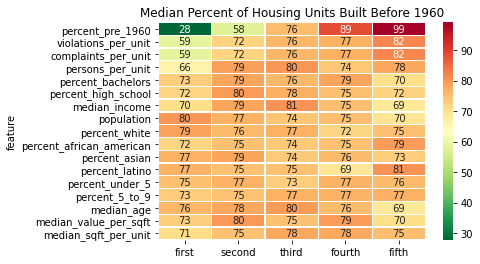

In [15]:
features = ['violations_per_unit','complaints_per_unit','persons_per_unit','percent_bachelors', 'percent_high_school', 'median_income',
       'population', 'percent_white', 'percent_african_american',
       'percent_asian', 'percent_latino', 'percent_under_5', 'percent_5_to_9',
       'median_age', 'median_value_per_sqft',
       'median_sqft_per_unit']
get_medians_by_quintiles(tracts, features, 'percent_pre_1960', 'Median Percent of Housing Units Built Before 1960')

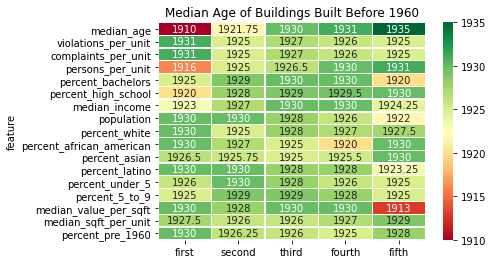

In [16]:
features = ['violations_per_unit','complaints_per_unit','persons_per_unit','percent_bachelors', 'percent_high_school', 'median_income',
       'population', 'percent_white', 'percent_african_american',
       'percent_asian', 'percent_latino', 'percent_under_5', 'percent_5_to_9',
       'median_value_per_sqft',
       'median_sqft_per_unit','percent_pre_1960']
get_medians_by_quintiles(tracts, features, 'median_age', 'Median Age of Buildings Built Before 1960')

In [9]:
print('All lots')
print(len(all_lots))
print('Pre-1960 lots')
print(len(lots))
print('Pre-1960 lots with at least one violation')
print(len(lots[lots.violations > 0]))
print('Lots with at least one successfully inspected complaint')
print(len(lots[(lots['violation_complaints'] > 0) | (lots['no_violation_complaints'] > 0)]))


All lots
196043
Pre-1960 lots
156383
Pre-1960 lots with at least one violation
21094
Lots with at least one successfully inspected complaint
18921


In [10]:
print('Tracts')
print(len(tracts))
print('Tracts with at least one violation')
print(len(tracts[tracts.violations > 0]))
print('Tracts in upper quartile of african american')
print(len(tracts[(tracts.percent_african_american >= 48)]))
print('Tracts with at least one violation and in upper quartile of african american')
print(len(tracts[(tracts.violations > 0) & (tracts.percent_african_american >= 48)]))
print('Tracts in lower quartile of african american')
print(len(tracts[(tracts.percent_white <= 3.6)]))
print('Tracts with at least one violation and in lower quartile of african american')
print(len(tracts[(tracts.violations > 0) & (tracts.percent_white <= 3.6)]))

Tracts
2167
Tracts with at least one violation
1550
Tracts in upper quartile of african american
513
Tracts with at least one violation and in upper quartile of african american
349
Tracts in lower quartile of african american
84
Tracts with at least one violation and in lower quartile of african american
43


In [11]:
print('Lots')
print(len(lots))
print('Lots with at least one violation')
print(len(lots[lots.violations > 0]))
print( round((len(lots[lots.violations > 0]) / len(lots) * 100),2) )
print('Lots with at least one complaint')
print(len(lots[lots.complaints > 0]))
print( round((len(lots[lots.complaints > 0]) / len(lots) * 100),2) )
print('Lots with at least one violation complaint')
print(len(lots[lots.violation_complaints > 0]))
print( round((len(lots[lots.violation_complaints > 0]) / len(lots) * 100),2) )
print('Lots with at least one no violation complaint')
print(len(lots[lots.no_violation_complaints > 0]))
print( round((len(lots[lots.no_violation_complaints > 0]) / len(lots) * 100),2) )
print('Lots with at least one no entry complaint')
print(len(lots[lots.no_entry_complaints > 0]))
print( round((len(lots[lots.no_entry_complaints > 0]) / len(lots) * 100),2) )



Lots
156383
Lots with at least one violation
21094
13.49
Lots with at least one complaint
21467
13.73
Lots with at least one violation complaint
13756
8.8
Lots with at least one no violation complaint
13152
8.41
Lots with at least one no entry complaint
9983
6.38


In [17]:
violations.dtypes

NameError: name 'violations' is not defined